<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Импортируем все нужные библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
import time

Для начала импортируем наш датасет. Сразу уточняем что в первом столбце находятся даты, которые нужно спарсить и сделать индексом. 

In [2]:
import os

pth1 = '/datasets/taxi.csv'
pth11 = 'taxi.csv'

if os.path.exists(pth1):
    taxi = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth11):
    taxi = pd.read_csv(pth11, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')

pd.set_option('display.max_columns', None)

Первично ознакомимся с данными

In [3]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


В целом, неудивительно, что они состоят лишь из временных рядов и количества заказов. Тут у нас целевая переменная num_oders, а все остальное мы будем делать сами. 

Отсортируем даты (в индексах) по возрастанию

In [4]:
taxi.sort_index(inplace=True)

In [5]:
taxi.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [6]:
taxi.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Всего наблюдений: 26,496
Среднее количество заказов: ~14
Стандартное отклонение: ~9.21, что указывает на высокую вариативность 
Минимальное количество заказов: 0
Максимальное количество заказов: 119
Медиана: 13
25% заказов имеют менее 8, а 75% заказов менее 19

## Анализ

In [7]:
hourly_data = taxi.resample('1H').sum()

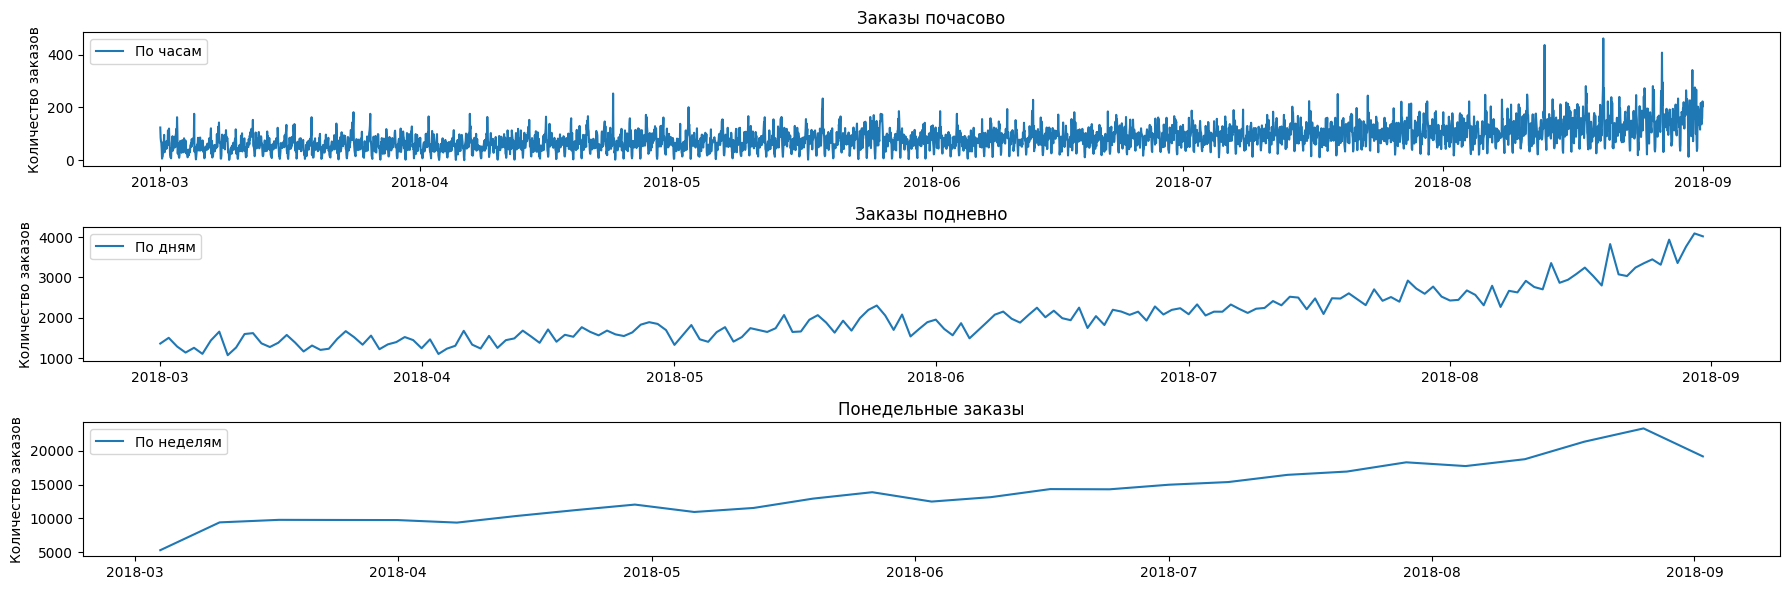

In [8]:
daily_data = taxi.resample('D').sum()
weekly_data = taxi.resample('W').sum()
plt.figure(figsize=(18, 6))
plt.subplot(3, 1, 1)
plt.plot(hourly_data, label='По часам')
plt.title('Заказы почасово')
plt.ylabel('Количество заказов')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(daily_data, label='По дням')
plt.title('Заказы подневно')
plt.ylabel('Количество заказов')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(weekly_data, label='По неделям')
plt.title('Понедельные заказы')
plt.ylabel('Количество заказов')
plt.legend()
plt.tight_layout()
plt.show()

Почасовые заказы: Показывают значительные колебания, значит в разное время суток разный спрос.

Ежедневные заказы: Наблюдается некоторая вариабельность, которая может отражать ежедневные изменения в спросе.

Еженедельные заказы: Представляют более общую картину, показывая тренды и возможные сезонные колебания на уровне недель.

Теперь изучим непосредственно тренды и сезонность

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [10]:
period = 144  # Период сезонности для данных с 10-минутными интервалами
original_decomposition = seasonal_decompose(taxi['num_orders'], model='additive', period=period)
original_trend = original_decomposition.trend
original_seasonal = original_decomposition.seasonal
original_residual = original_decomposition.resid

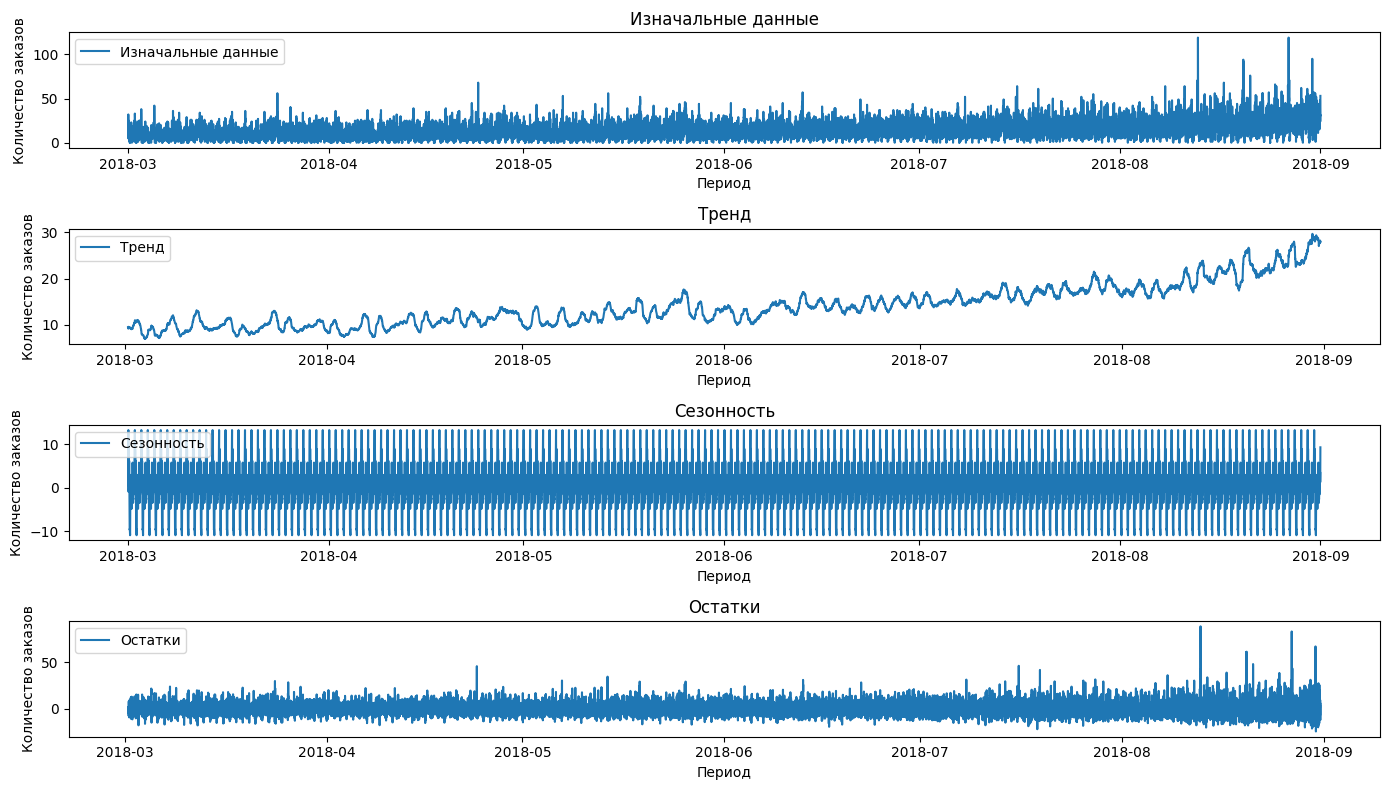

In [11]:
plt.figure(figsize=(14, 8))
plt.subplot(4, 1, 1)
plt.plot(taxi['num_orders'], label='Изначальные данные')
plt.legend(loc='upper left')
plt.title('Изначальные данные')
plt.ylabel('Количество заказов')
plt.xlabel('Период')
plt.subplot(4, 1, 2)
plt.plot(original_trend, label='Тренд')
plt.legend(loc='upper left')
plt.title('Тренд')
plt.ylabel('Количество заказов')
plt.xlabel('Период')
plt.subplot(4, 1, 3)
plt.plot(original_seasonal, label='Сезонность')
plt.legend(loc='upper left')
plt.title('Сезонность')
plt.ylabel('Количество заказов')
plt.xlabel('Период')
plt.subplot(4, 1, 4)
plt.plot(original_residual, label='Остатки')
plt.legend(loc='upper left')
plt.title('Остатки')
plt.ylabel('Количество заказов')
plt.xlabel('Период')
plt.tight_layout()
plt.show()

Тренд выявляет общее направление изменения количества заказов со временем. Видно, как тренд изменяется, это указывает на долгосрочные изменения в объеме

Сезонность выявляет повторяющиеся краткосрочные паттерны (еженедельные колебания)

Остатки отображают часть данных, которую нельзя объяснить трендом и сезонностью (случайные колебания и другие факторы)

Исходя из графиков видно, что в данных присутствуют и тренды, и сезонные колебания

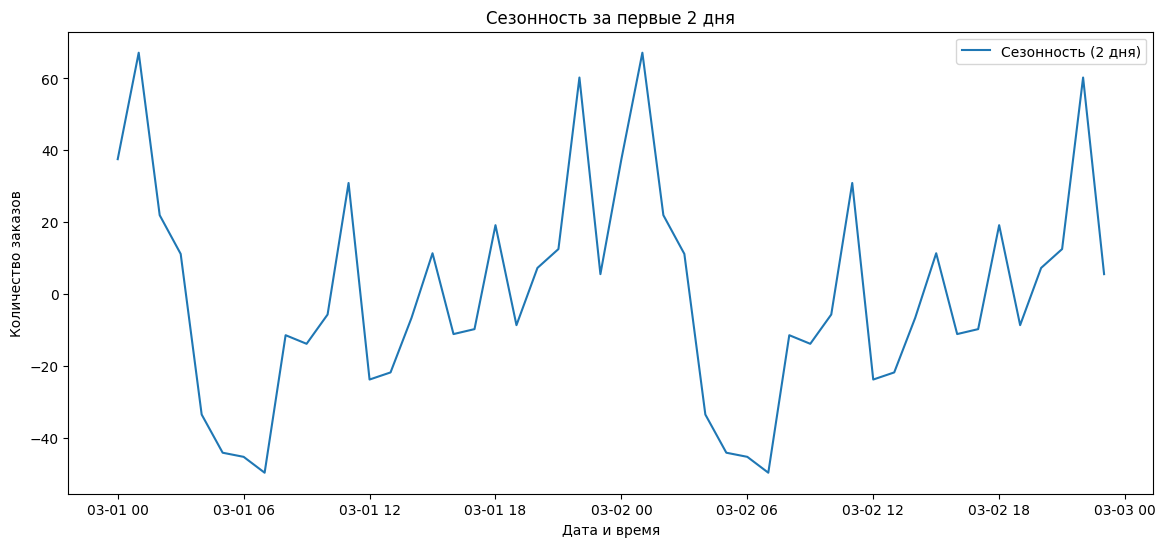

In [12]:
short_period_data = hourly_data[:48]
short_decomposition = seasonal_decompose(short_period_data, model='additive')
short_seasonal = short_decomposition.seasonal
plt.figure(figsize=(14, 6))
plt.plot(short_seasonal, label='Сезонность (2 дня)')
plt.title('Сезонность за первые 2 дня')
plt.ylabel('Количество заказов')
plt.xlabel('Дата и время')
plt.legend()
plt.show()

Природа сезонности: Наблюдаемая сезонность, скорее всего, часовая, тк видно повторяющиеся паттерны в течение каждого дня.

Пики и спады: Можно заметить, что пики заказов, вероятно, приходятся на определенные часы (например, утро и вечер), в то время как в другие периоды (например, ночью) наблюдаются спады. Это может быть связано с повышенным спросом на такси в часы пик и снижением спроса в ночное время.

Особенности сезонности в контексте заказов такси в аэропортах: Спрос на такси в аэропортах может быть обусловлен расписанием рейсов, что приводит к пикам в определенные часы. Например, прибытие или отправление большого количества рейсов может увеличивать спрос на такси.

In [13]:
rolling_mean = hourly_data.rolling(window=12, closed='left').mean().shift(1)

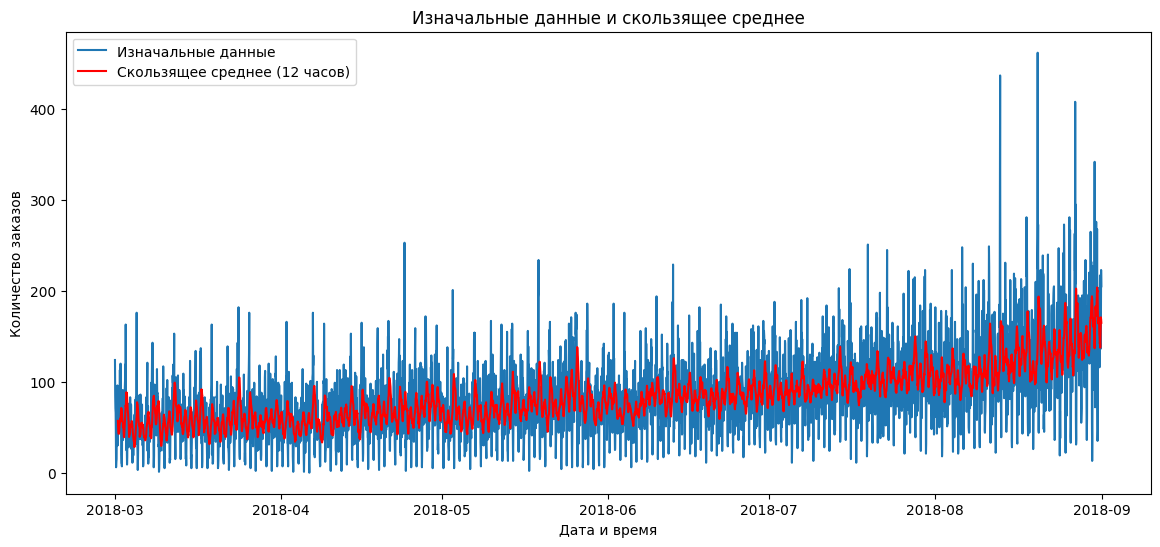

In [14]:
plt.figure(figsize=(14, 6))
plt.plot(hourly_data, label='Изначальные данные')
plt.plot(rolling_mean, color='red', label='Скользящее среднее (12 часов)')
plt.title('Изначальные данные и скользящее среднее')
plt.ylabel('Количество заказов')
plt.xlabel('Дата и время')
plt.legend()
plt.show()

На втором графике скользящее среднее (12 часов)
В данном случае, мы видим, что тенденция со временем идет вверх, а значит ряд нестационарный. 

## Обучение

Создадим дополнительные признаки чтобы улучшить показания будущих моделей

In [15]:
taxi['hour'] = taxi.index.hour
taxi['day_of_week'] = taxi.index.dayofweek
taxi['day'] = taxi.index.day

In [16]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
make_features(hourly_data,24,20)

In [17]:
# Разделение на тренировочный и тестовый наборы
train, test = train_test_split(hourly_data, shuffle=False, random_state=42, test_size=0.1)
train = train.dropna()

# Разделение на признаки и целевую переменную
train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']
test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

In [18]:
def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

Для начала используем Random Forest

In [19]:
splits = TimeSeriesSplit(n_splits=3)
RF = RandomForestRegressor(random_state=42)
parametrs_rf = {"max_depth": [1, 10], "n_estimators": [100, 150]}
RF_grid = GridSearchCV(RF, parametrs_rf, cv=splits, verbose=True, n_jobs=-1, scoring='neg_mean_squared_error')
RF_grid.fit(train_features, train_target)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 10], 'n_estimators': [100, 150]},
             scoring='neg_mean_squared_error', verbose=True)

Теперь CatBoost

In [20]:
catboost = CatBoostRegressor(loss_function='RMSE', random_state=42)
parameters_cat = {'depth': [5, 10], 'learning_rate': np.arange(0.1, 1, 0.2)}
catboost_grid = catboost.grid_search(parameters_cat, Pool(train_features, train_target), cv=splits, verbose=True)

0:	learn: 72.5229213	test: 107.2720048	best: 107.2720048 (0)	total: 59.9ms	remaining: 59.9s
1:	learn: 66.4866844	test: 100.5970995	best: 100.5970995 (1)	total: 61.3ms	remaining: 30.6s
2:	learn: 61.1051746	test: 94.0601785	best: 94.0601785 (2)	total: 62.7ms	remaining: 20.8s
3:	learn: 56.2214966	test: 87.8307299	best: 87.8307299 (3)	total: 64.1ms	remaining: 16s
4:	learn: 51.8456834	test: 82.0704001	best: 82.0704001 (4)	total: 65.6ms	remaining: 13.1s
5:	learn: 48.0440413	test: 77.3527654	best: 77.3527654 (5)	total: 67.2ms	remaining: 11.1s
6:	learn: 44.6693860	test: 73.3762551	best: 73.3762551 (6)	total: 68.2ms	remaining: 9.67s
7:	learn: 41.8370153	test: 69.8863876	best: 69.8863876 (7)	total: 69.1ms	remaining: 8.57s
8:	learn: 39.2656835	test: 66.5632943	best: 66.5632943 (8)	total: 70.5ms	remaining: 7.76s
9:	learn: 36.9963988	test: 63.7802929	best: 63.7802929 (9)	total: 71.7ms	remaining: 7.09s
10:	learn: 34.9182527	test: 60.8713486	best: 60.8713486 (10)	total: 72.8ms	remaining: 6.54s
11:	le

Выбираем лучшие параметры кэта и обучаемся на них

In [21]:
final_cat = CatBoostRegressor(depth=catboost_grid["params"]["depth"], 
                              learning_rate=catboost_grid["params"]['learning_rate'],
                              loss_function='RMSE', verbose=100)
final_cat.fit(Pool(train_features, train_target))

0:	learn: 36.9507113	total: 768us	remaining: 768ms
100:	learn: 21.4505201	total: 104ms	remaining: 925ms
200:	learn: 18.5081406	total: 193ms	remaining: 768ms
300:	learn: 16.4568312	total: 285ms	remaining: 661ms
400:	learn: 14.9873624	total: 377ms	remaining: 563ms
500:	learn: 13.7024129	total: 470ms	remaining: 468ms
600:	learn: 12.5705113	total: 562ms	remaining: 373ms
700:	learn: 11.5649984	total: 652ms	remaining: 278ms
800:	learn: 10.8073025	total: 741ms	remaining: 184ms
900:	learn: 10.0134570	total: 830ms	remaining: 91.2ms
999:	learn: 9.3176203	total: 921ms	remaining: 0us


Теперь LGBM

In [22]:
parameters_light = {
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 10,
    'learning_rate': 0.1,
    'random_state': 42
}
lgb_train = lgb.Dataset(train_features, train_target)
cv_results = lgb.cv(parameters_light, lgb_train, num_boost_round=1000, nfold=3, stratified=False)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4844
[LightGBM] [Info] Number of data points in the train set: 2632, number of used features: 27
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't expl

In [23]:
best_round = np.argmin(cv_results['valid rmse-mean']) + 1
final_lgbm_model = lgb.train(parameters_light, lgb_train, num_boost_round=best_round)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4844
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 27
[LightGBM] [Info] Start training from score 78.421013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

Выведем результаты всех моделей 

In [24]:
best_rmse_rf = np.sqrt(-RF_grid.best_score_)
print(f'Лучший RMSE для RandomForest на кросс-валидации: {best_rmse_rf}')

Лучший RMSE для RandomForest на кросс-валидации: 27.998104237374324


In [25]:
best_rmse_catboost = min(catboost_grid['cv_results']['test-RMSE-mean'])
print(f'Лучший RMSE для CatBoost на кросс-валидации: {best_rmse_catboost}')

Лучший RMSE для CatBoost на кросс-валидации: 26.920808045259278


In [26]:
best_lgbm_rmse = min(cv_results['valid rmse-mean'])
print(f'Лучший RMSE для LightGBM на кросс-валидации: {best_lgbm_rmse}')

Лучший RMSE для LightGBM на кросс-валидации: 23.31655834051549


Таким образом к тестированию проходит модель LGBM

## Тестирование

In [27]:
lgbm_test_predictions = final_lgbm_model.predict(test_features)
rmse_lgbm_test = np.sqrt(mean_squared_error(test_target, lgbm_test_predictions))
print(f'RMSE LightGBM на тестовом наборе: {rmse_lgbm_test}')

RMSE LightGBM на тестовом наборе: 42.70872670759838


Итак, получаем что и на тестовом наборе данных наша модель LGBM показала очень хороший результат, таким образом, учитывая опыт предыдущего проекта (то бишь анализ скоростей), как раз на LGBM мы и остановимся, так как она сочетает в себе все прелести, от скорости работы, до простоты использования и качества предсказаний. 
Если подытожить, мы получаем по-своему интересный проект связанный с временными рядами, так как до этого мы с ними не сталкивались. На первых парах было непросто, так как это действительно специфический тип данных, который для человека вряд ли будет информативным. Особенностями работы стало применение таких инструментов как ресемплирование, использование в анализе тренда, сезонностей и остатков, чего ранее не встречалось. Приходилось по-разному разбивать наблюдения, так как во временных рядах важно смотреть тенденции как по часам суток, так и по дням недели а так же месяцам, это было необычно. 